# LOAD

In [1]:
import os
import os
import json
import re
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split


In [2]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- CONFIGURATION ---
# Setting the root to your unzipped folder
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/archive"

Mounted at /content/drive


In [3]:
def locate_dataset(root_path):
    root = Path(root_path)

    json_path = list(root.rglob("VQA_RAD Dataset Public.json"))[0]
    img_dir = list(root.rglob("VQA_RAD Image Folder"))[0]
    return str(json_path), str(img_dir)
json_path, img_dir = locate_dataset(DATA_ROOT)
print(f"JSON: {json_path}")
print(f"Image Catalog: {img_dir}")

JSON: /content/drive/MyDrive/Colab Notebooks/archive/VQA_RAD Dataset Public.json
Image Catalog: /content/drive/MyDrive/Colab Notebooks/archive/VQA_RAD Image Folder


In [4]:
# ==========================================
# 2. Text cleaning
# ==========================================
def clean_text(text):
    """
  Standardized text cleaning:
  1. Convert to lowercase
  2. Remove punctuation (keep letters and numbers)
  3. Remove extra spaces

    """
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text) # Replace non-alphanumeric characters with spaces.
    text = re.sub(r"\s+", " ", text).strip()  # merge spaces
    return text

In [5]:
# ==========================================
# 3. Loading and partitioning logic
# ==========================================
# load data
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data)

# Basic cleaning
df["image_name"] = df["image_name"].astype(str)
df["question"] = df["question"].apply(clean_text)
df["answer"] = df["answer"].apply(clean_text)
df["answer_type"] = df["answer_type"].str.upper()

# Differentiate the test set (based on the official phrase_type)
test_mask = df["phrase_type"].str.lower().str.startswith("test")
test_df = df[test_mask].reset_index(drop=True)
train_pool = df[~test_mask].reset_index(drop=True)

# Splitting the training set vs. validation set
# Key point: The partitioning must be based on [image_name] to prevent issues from the same image from leaking to the validation set.
unique_images = train_pool["image_name"].unique()
train_imgs, val_imgs = train_test_split(unique_images, test_size=0.15, random_state=42) #  42

train_df = train_pool[train_pool["image_name"].isin(train_imgs)].reset_index(drop=True)
val_df = train_pool[train_pool["image_name"].isin(val_imgs)].reset_index(drop=True)

In [6]:
# ==========================================
# 4. CSV
# ==========================================
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

print(f"training set: {len(train_df)}")
print(f"Validation set : {len(val_df)}")
print(f"Test set : {len(test_df)}")

training set: 1530
Validation set : 267
Test set : 451


# EDA

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 1. Read the training set
train_df = pd.read_csv("train_split.csv")

# Set drawing style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

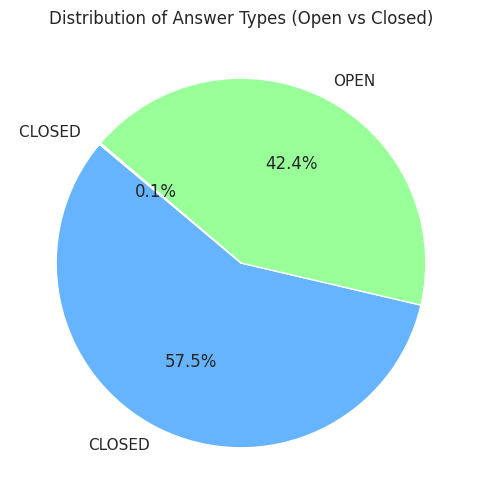

In [8]:
# ==========================================
# Open vs Closed
# ==========================================
plt.figure(figsize=(6, 6))
type_counts = train_df['answer_type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99'])
plt.title('Distribution of Answer Types (Open vs Closed)')
plt.show()


/tmp/ipython-input-2667168456.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=q_counts.values, y=q_counts.index, palette="viridis")


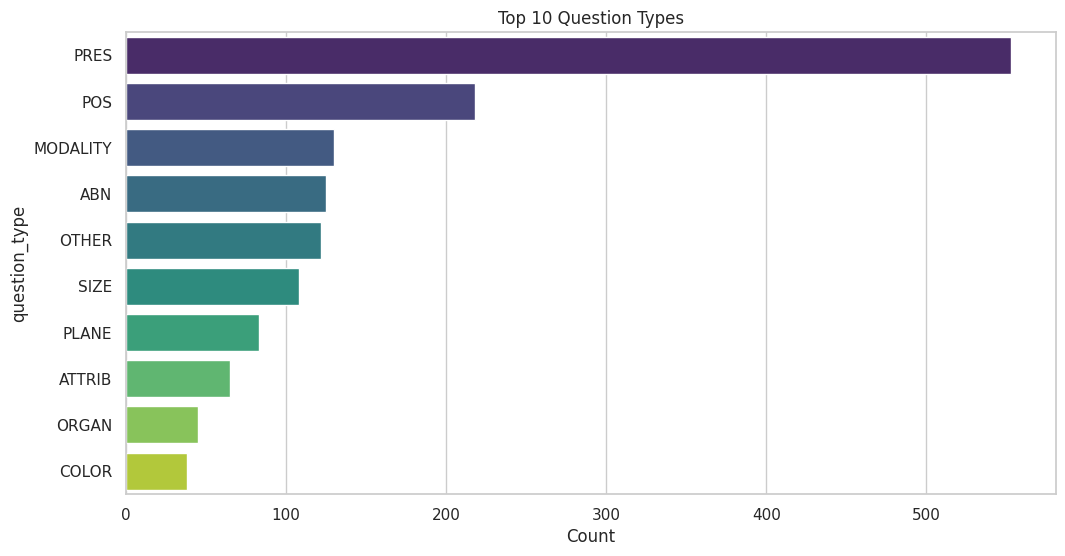

In [9]:
# ==========================================
# Question Types
# ==========================================
plt.figure(figsize=(12, 6))
if 'question_type' in train_df.columns:
    q_counts = train_df['question_type'].value_counts().head(10)
    sns.barplot(x=q_counts.values, y=q_counts.index, palette="viridis")
    plt.title('Top 10 Question Types')
    plt.xlabel('Count')
    plt.show()
else:
    print("no 'question_type'")

/tmp/ipython-input-1554309287.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_answers.values, y=top_answers.index, palette="magma")


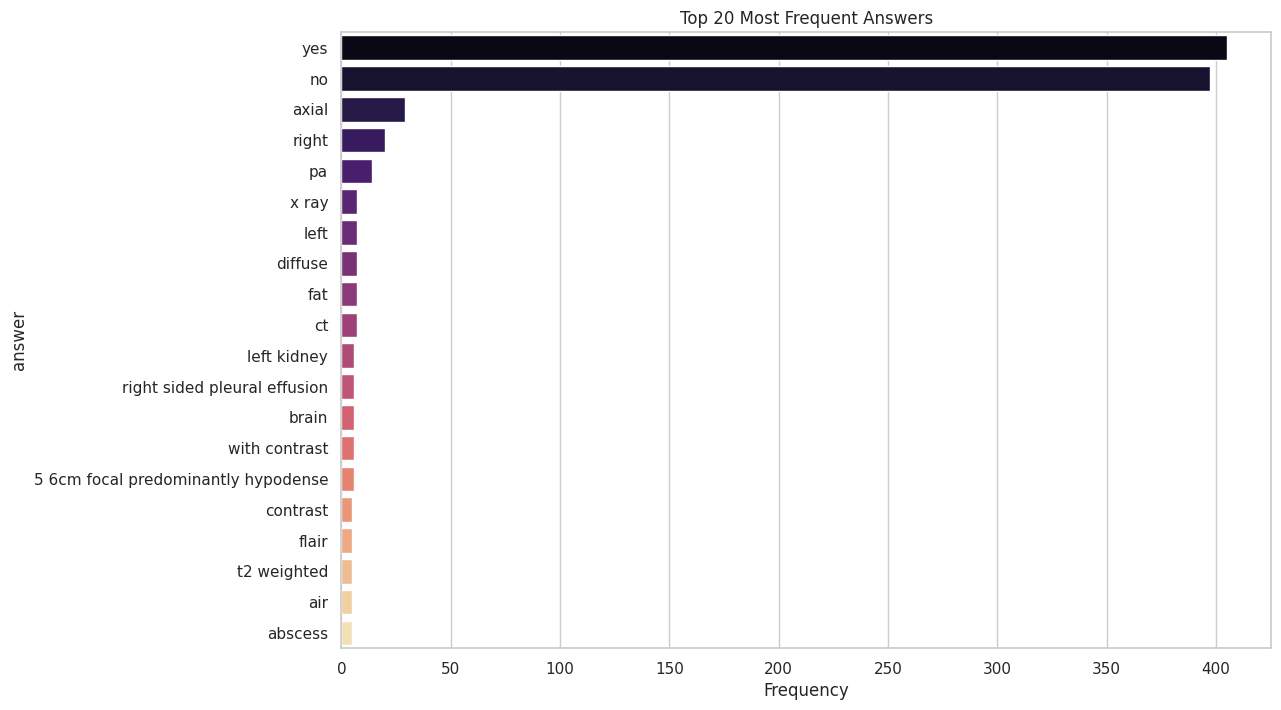

In [10]:
# ==========================================
# Top 20 answer word frequencies (long-tail distribution)
# ==========================================
plt.figure(figsize=(12, 8))
top_answers = train_df['answer'].value_counts().head(20)
sns.barplot(x=top_answers.values, y=top_answers.index, palette="magma")
plt.title('Top 20 Most Frequent Answers')
plt.xlabel('Frequency')
plt.show()


In [11]:
# ==========================================
# Calculate the simplest baseline
# ==========================================
most_common_answer = train_df['answer'].mode()[0]
accuracy_majority_vote = (train_df['answer'] == most_common_answer).mean()
print("-" * 30)
print(f"The most frequent answer in the training set is: '{most_common_answer}'")
print(f"If the model always only answers regardless of the question... '{most_common_answer}'，Its accuracy will be: {accuracy_majority_vote:.2%}")

------------------------------
The most frequent answer in the training set is: 'yes'
If the model always only answers regardless of the question... 'yes'，Its accuracy will be: 26.47%


# DATA PROCESS

In [21]:

from PIL import Image
import nltk
from collections import Counter
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

In [13]:
# ==========================================
# Fix NLTK errors
# ==========================================
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [14]:
# ==========================================
# Vocabulary Wrapper
# ==========================================
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0


        self.add_word("<pad>")  # Fill in the blanks (index 0)
        self.add_word("<start>")# Sentence beginning (index 1)
        self.add_word("<end>")  # Sentence end (index 2)
        self.add_word("<unk>")  # Unknown (index 3)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx["<unk>"]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

# built vocabulary
def build_vocab(df, threshold=1):
    counter = Counter()
    for text in pd.concat([df['question'], df['answer']]):
        #  word_tokenize need punkt_tab
        tokens = nltk.tokenize.word_tokenize(str(text).lower())
        counter.update(tokens)

    vocab = Vocabulary()
    for word, cnt in counter.items():
        if cnt >= threshold:
            vocab.add_word(word)

    print(f"The vocabulary list is complete! Total number of words:: {len(vocab)}")
    return vocab

In [15]:
# ==========================================
# 2. Custom dataset classes (including data augmentation)
# ==========================================
class VQADataset(Dataset):
    def __init__(self, df, vocab, img_dir, transform=None, max_seq_len=20):
        self.df = df
        self.vocab = vocab
        self.img_dir = img_dir
        self.transform = transform
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 1. Image processing
        img_path = f"{self.img_dir}/{row['image_name']}"
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Return to black when encountering bad images to prevent training interruption.
            print(f"Warning: Could not load {img_path}, using black image.")
            image = Image.new('RGB', (224, 224))

        if self.transform:
            image = self.transform(image)

        # 2. Problem Solving
        q_tokens = nltk.tokenize.word_tokenize(str(row['question']).lower())
        q_indices = [self.vocab("<start>")] + \
                    [self.vocab(token) for token in q_tokens] + \
                    [self.vocab("<end>")]

        if len(q_indices) > self.max_seq_len:
            q_indices = q_indices[:self.max_seq_len]
        else:
            q_indices += [self.vocab("<pad>")] * (self.max_seq_len - len(q_indices))

        return image, torch.tensor(q_indices), row['answer']

In [16]:
# ==========================================
# 3. Define data augmentation
# ==========================================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [17]:
# ==========================================
# 4. Instantiation
# ==========================================

train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")

vocab = build_vocab(train_df, threshold=1)
print(f"Vocab Size: {len(vocab)}")

The vocabulary list is complete! Total number of words:: 1173
Vocab Size: 1173


In [19]:
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")
test_df = pd.read_csv("test_split.csv")

def clean_and_overwrite(df, name):
    original_count = len(df)

    # Delete null values
    df = df.dropna(subset=['image_name', 'question', 'answer'])

    # Filter answer types
    # Keep only 'CLOSED' and 'OPEN', remove any strange markings.
    df = df[df['answer_type'].isin(['CLOSED', 'OPEN'])]

    # Clean the text again
    df['answer'] = df['answer'].astype(str).str.strip().str.lower()
    df['question'] = df['question'].astype(str).str.strip().str.lower()

    # Delete excessively long answers
    df = df[df['answer'].apply(lambda x: len(str(x).split()) < 15)]

    # Filter out meaningless samples whose answer is "other".
    df = df[df['answer'] != "other"]

    final_count = len(df)
    print(f"[{name}] Before cleaning: {original_count} -> After cleaning: {final_count} (Deleted {original_count - final_count} )")
    return df

# Perform cleaning
train_df_clean = clean_and_overwrite(train_df, "Train")
val_df_clean = clean_and_overwrite(val_df, "Val")
test_df_clean = clean_and_overwrite(test_df, "Test")

# Overwrite Save CSV
train_df_clean.to_csv("train_split.csv", index=False)
val_df_clean.to_csv("val_split.csv", index=False)
test_df_clean.to_csv("test_split.csv", index=False)


[Train] Before cleaning: 1527 -> After cleaning: 1527 (Deleted 0 )
[Val] Before cleaning: 267 -> After cleaning: 267 (Deleted 0 )
[Test] Before cleaning: 451 -> After cleaning: 451 (Deleted 0 )


In [20]:
train_df_clean = pd.read_csv("train_split.csv")

final_vocab = build_vocab(train_df_clean, threshold=1)

print(f"Final Vocabulary Size: {len(final_vocab)}")
print(f"Training Samples: {len(train_df_clean)}")

The vocabulary list is complete! Total number of words:: 1169
Final Vocabulary Size: 1169
Training Samples: 1527


# Modle Training

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import copy

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Training on: {device}")

 Training on: cuda


In [24]:
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")

vocab = build_vocab(train_df, threshold=1)
print(f"Final Vocab Size: {len(vocab)}")

The vocabulary list is complete! Total number of words:: 1169
Final Vocab Size: 1169


In [25]:
# Construct an answer category mapping (Answer -> Label)
answer_counts = train_df['answer'].value_counts()
ans2idx = {ans: i for i, ans in enumerate(answer_counts.index)}
idx2ans = {i: ans for ans, i in ans2idx.items()}
NUM_CLASSES = len(ans2idx)
print(f"Number of Answer Classes: {NUM_CLASSES}")

Number of Answer Classes: 371


In [26]:
# ==========================================
# Dataset
# ==========================================
class VQADatasetClassification(VQADataset):
    def __init__(self, df, vocab, ans2idx, img_dir, transform=None):
        super().__init__(df, vocab, img_dir, transform)
        self.ans2idx = ans2idx

    def __getitem__(self, idx):
        img, q_tensor, raw_ans = super().__getitem__(idx)
        # If the answer in the validation set has not appeared in the training set, mark it as -1 (ignored when calculating the loss).
        label = self.ans2idx.get(raw_ans, -1)
        return img, q_tensor, torch.tensor(label, dtype=torch.long)

# Loader
train_ds = VQADatasetClassification(train_df, vocab, ans2idx, img_dir, transform=train_transform)
val_ds = VQADatasetClassification(val_df, vocab, ans2idx, img_dir, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

In [27]:
# ==========================================
# 3. (CNN + LSTM)
# ==========================================
class VQAModel(nn.Module):
    def __init__(self, vocab_size, num_classes, embed_dim=256, hidden_dim=512):
        super(VQAModel, self).__init__()

        # --- Image Encoder ---
        resnet = models.resnet18(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])
        self.img_fc = nn.Linear(512, hidden_dim)
        self.bn_img = nn.BatchNorm1d(hidden_dim)

        # --- Question Encoder ---
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.bn_txt = nn.BatchNorm1d(hidden_dim)

        # --- Classifier ---
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # High dropout for small dataset
            nn.Linear(512, num_classes)
        )

    def forward(self, images, questions):
        # Image
        img_feat = self.resnet_features(images).view(images.size(0), -1)
        img_feat = torch.relu(self.bn_img(self.img_fc(img_feat)))

        # Text
        embeds = self.embedding(questions)
        _, (h_n, _) = self.lstm(embeds)
        txt_feat = torch.relu(self.bn_txt(h_n.squeeze(0)))

        # Fusion
        combined = torch.cat((img_feat, txt_feat), dim=1)
        output = self.classifier(combined)
        return output

In [28]:
# ==========================================
# 4. Training Function
# ==========================================
model = VQAModel(vocab_size=len(vocab), num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Lower the learning rate to prevent oscillations
criterion = nn.CrossEntropyLoss(ignore_index=-1) # Ignore unseen answers

def train_engine(epochs=30):
    best_acc = 0.0
    print("Start Training...")

    for epoch in range(epochs):
        # --- Train ---
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for imgs, qs, labels in train_loader:
            imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs, qs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            # Only the accuracy of valid labels is counted.
            mask = (labels != -1)
            train_correct += (preds[mask] == labels[mask]).sum().item()
            train_total += mask.sum().item()

        epoch_loss = train_loss / len(train_df)
        epoch_acc = train_correct / train_total if train_total > 0 else 0

        # --- Val ---
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for imgs, qs, labels in val_loader:
                imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)
                outputs = model(imgs, qs)
                _, preds = torch.max(outputs, 1)

                mask = (labels != -1)
                val_correct += (preds[mask] == labels[mask]).sum().item()
                val_total += mask.sum().item()

        val_acc = val_correct / val_total if val_total > 0 else 0

        print(f"Epoch {epoch+1:02d} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save Best
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_cnn_lstm.pth")
            print(f"  >>> New Best Model Saved! (Acc: {best_acc:.4f})")

    print(f"\n Final Best Validation Accuracy: {best_acc:.4f}")

train_engine(epochs=30)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


Start Training...
Epoch 01 | Loss: 4.7359 | Train Acc: 0.2652 | Val Acc: 0.4053
  >>> New Best Model Saved! (Acc: 0.4053)
Epoch 02 | Loss: 3.5924 | Train Acc: 0.3117 | Val Acc: 0.4000
Epoch 03 | Loss: 3.3098 | Train Acc: 0.3274 | Val Acc: 0.4158
  >>> New Best Model Saved! (Acc: 0.4158)
Epoch 04 | Loss: 3.0831 | Train Acc: 0.3674 | Val Acc: 0.4158
Epoch 05 | Loss: 2.8997 | Train Acc: 0.3818 | Val Acc: 0.3947
Epoch 06 | Loss: 2.7478 | Train Acc: 0.4198 | Val Acc: 0.4421
  >>> New Best Model Saved! (Acc: 0.4421)
Epoch 07 | Loss: 2.5856 | Train Acc: 0.4434 | Val Acc: 0.3579
Epoch 08 | Loss: 2.4330 | Train Acc: 0.4669 | Val Acc: 0.4632
  >>> New Best Model Saved! (Acc: 0.4632)
Epoch 09 | Loss: 2.2920 | Train Acc: 0.4977 | Val Acc: 0.4105
Epoch 10 | Loss: 2.1281 | Train Acc: 0.5246 | Val Acc: 0.3789
Epoch 11 | Loss: 1.9705 | Train Acc: 0.5566 | Val Acc: 0.4474
Epoch 12 | Loss: 1.8363 | Train Acc: 0.5887 | Val Acc: 0.3895
Epoch 13 | Loss: 1.7436 | Train Acc: 0.5894 | Val Acc: 0.4000
Epoch 14

# Test Evaluation

In [34]:
# ==========================================
# 1. Prepare the test set
# ==========================================
test_df = pd.read_csv("test_split.csv")
print(f"Loading Test Set: {len(test_df)} samples")

# Use the previously defined Dataset class (Note: val_transform must be used; data augmentation is not allowed).
# Vocabulary and Ans2idx must reuse the ones from training!
test_ds = VQADatasetClassification(test_df, vocab, ans2idx, img_dir, transform=val_transform)
# `shuffle=False` must be set to `False` to ensure that the prediction order is consistent with the DataFrame.
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# ==========================================
# 2. Load the best model
# ==========================================
model = VQAModel(vocab_size=len(vocab), num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load("best_cnn_lstm.pth"))
model.eval()
print("Best model loaded successfully.")

# ==========================================
# 3. Performing inference
# ==========================================
all_preds = []
print("Running inference on Test Set...")

with torch.no_grad():
    for imgs, qs, labels in test_loader:
        imgs, qs = imgs.to(device), qs.to(device)
        outputs = model(imgs, qs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

# ==========================================
# 4. Calculate detailed metrics (Overall / Open / Closed)
# ==========================================
# Convert the prediction result (Index) back into a word (String) for human reading.
# If -1 (unseen) was predicted, temporarily switch to "<unk>".
pred_words = [idx2ans.get(p, "<unk>") for p in all_preds]

# The prediction results are concatenated into a DataFrame for easy comparison.
test_df['prediction'] = pred_words

# Calculate the accuracy function
def calculate_accuracy(df):
    # Simple string matching (compare all lowercase cases)

    correct = (df['prediction'] == df['answer'])
    return correct.mean()

# Overall accuracy
overall_acc = calculate_accuracy(test_df)

# Classification accuracy
closed_mask = test_df['answer_type'] == 'CLOSED'
open_mask = test_df['answer_type'] == 'OPEN'

closed_acc = calculate_accuracy(test_df[closed_mask])
open_acc = calculate_accuracy(test_df[open_mask])

print("\n" + "="*40)
print("Method 1 (CNN + LSTM) Final Results")
print("="*40)
print(f"Overall Accuracy: {overall_acc:.2%}")
print("-" * 20)
print(f"Closed-ended: {closed_acc:.2%}")
print(f"Open-ended: {open_acc:.2%}")
print("="*40)

# Sanity Check)
print("\n Prediction Sample Display:")
print(test_df[['question', 'answer', 'prediction', 'answer_type']].head(5))

Loading Test Set: 451 samples


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best model loaded successfully.
Running inference on Test Set...

Method 1 (CNN + LSTM) Final Results
Overall Accuracy: 37.03%
--------------------
Closed-ended: 57.35%
Open-ended: 6.15%

 Prediction Sample Display:
                                           question              answer  \
0           is there evidence of an aortic aneurysm                 yes   
1  is there airspace consolidation on the left side                 yes   
2                            is this an axial plane                 yes   
3                       how is the patient oriented  posterior anterior   
4         is there vascular pathology in this image                 yes   

  prediction answer_type  
0         no      CLOSED  
1         no      CLOSED  
2        yes      CLOSED  
3         pa        OPEN  
4         no      CLOSED  


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

y_true = []
y_pred = []


model.eval()
with torch.no_grad():
    for imgs, qs, labels in test_loader:
        imgs, qs = imgs.to(device), qs.to(device)
        outputs = model(imgs, qs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ==========================================
# 2.F1-Score
# ==========================================
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n" + "="*40)
print(f"Method 1 F1-Score")
print("="*40)
print(f"Weighted F1-Score: {f1:.4f}")
print("- If the F1 score is much lower than the accuracy score, it indicates that the model is severely unbalanced (scores only in major categories)")
print("- If the F1 score is close to the accuracy, it means that the model performs relatively evenly across all categories.")
print("="*40)



Method 1 F1-Score
Weighted F1-Score: 0.3325
- If the F1 score is much lower than the accuracy score, it indicates that the model is severely unbalanced (scores only in major categories)
- If the F1 score is close to the accuracy, it means that the model performs relatively evenly across all categories.


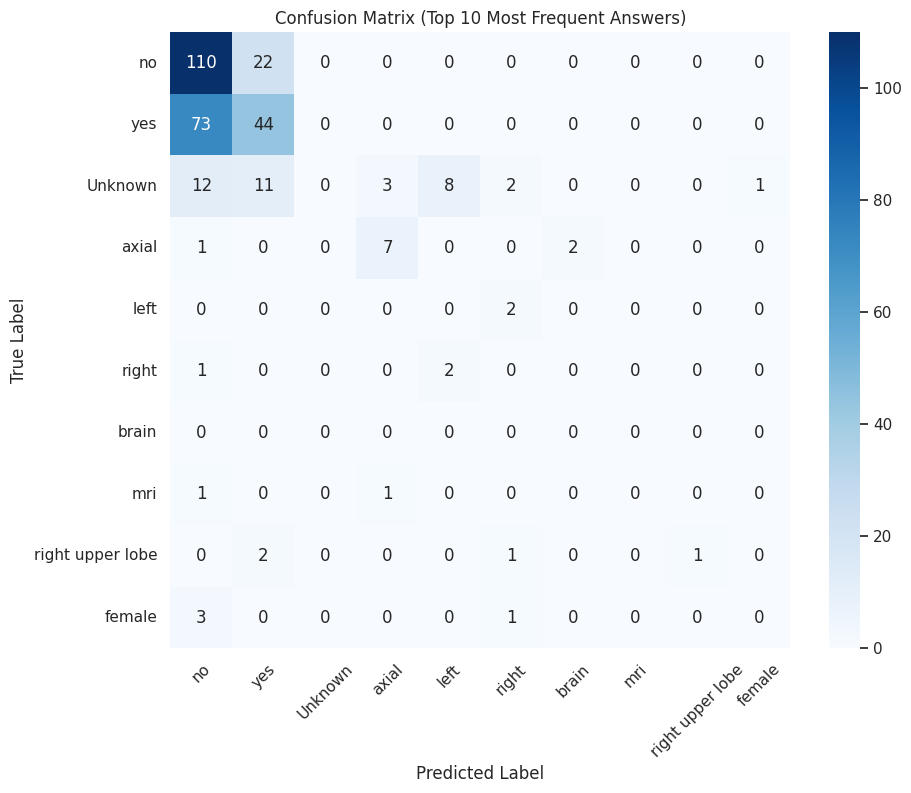


 Top 10 Classes Detailed Report:
                  precision    recall  f1-score   support

              no       0.55      0.83      0.66       132
             yes       0.56      0.38      0.45       117
         Unknown       0.00      0.00      0.00        37
           axial       0.64      0.70      0.67        10
            left       0.00      0.00      0.00         2
           right       0.00      0.00      0.00         3
           brain       0.00      0.00      0.00         0
             mri       0.00      0.00      0.00         2
right upper lobe       1.00      0.25      0.40         4
          female       0.00      0.00      0.00         4

        accuracy                           0.52       311
       macro avg       0.27      0.22      0.22       311
    weighted avg       0.48      0.52      0.48       311



In [39]:

# ==========================================
# 3. Draw a confusion matrix (Top 10 Answers)
# ==========================================

top_counts = pd.Series(y_true).value_counts().head(10)
top_indices = top_counts.index.tolist()
top_names = [idx2ans.get(i, "Unknown") for i in top_indices]


filtered_true = []
filtered_pred = []

for t, p in zip(y_true, y_pred):
    if t in top_indices and p in top_indices:
        filtered_true.append(t)
        filtered_pred.append(p)


cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)

#
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_names, yticklabels=top_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Top 10 Most Frequent Answers)')
plt.xticks(rotation=45)
plt.show()

# ==========================================
# 4. Classification Report
# ==========================================
print("\n Top 10 Classes Detailed Report:")
print(classification_report(filtered_true, filtered_pred, labels=top_indices, target_names=top_names, zero_division=0))